# AIPI 590 - XAI | Assignment #09

## Mechanistic Interpretability

## Rebecca Du (rrd17)

**AI was used in this assignment and is cited appropriately where used**

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rrdu/AIPI-590/blob/main/HW9/AIPI590_MechanisticInterp.ipynb)



In this notebook, I will create a simple MLP that performs XOR classification, then investigate the role of specific neurons in influencing model performance.

The notebook is structured as follows:

**MLP Task:** XOR/Parity classification

1) **Part 1: Setup**
    - 1.1) Data Generation
    - 1.2) Tiny MLP Creation, Training, Evaluation
2) **Part 2: Exploration**
    - 2.1) Inspect Weights & Activations
    - 2.2) Neuron Selectivity Curves
    - 2.3) Neuron Ablation
3) **Part 3: Explanation**
4) **Part 4: Reflection**

## Part 1: Setup

First, let's define what XOR classification is.

XOR is a binary operation that takes 2 binary inputs and produces 1 binary output. The output will be 1 **only** when the inputs are different, so:
  - XOR(0, 0) = 0
  - XOR(0, 1) = 1
  - XOR(1, 0) = 1
  - XOR(1, 1) = 0

In other words, it checks the the **parity** (whether the input is even or odd).

**For our problem, we have an 8-bit input that extends the XOR function to multiple inputs. Each 0 and 1 contributes to flipping the parity between even and odd.**

This has been a classic challenge for single-layer perceptrons since they are unable to create a boundary that separates the 0 and 1 classes.

Thus, multiple layers are needed for the problem, which makes it perfect for our investigation.

### 1.1) Data Generation

To start, we need to generate some data and set up the MLP model whose 'brain' we'll be picking.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools

import matplotlib.pyplot as plt

import random
import numpy as np

In [2]:
#Code in this cell was generated using GPT-5 on 10/26/2025 at 1:25 PM
def generate_xor_data(seq_length=8, val_frac=0.2, center_inputs=True):
  '''Generate the full XOR (parity) dataset by enumerating all 2^seq_length binary combinations'''
  #Enumerate all binary combinations
  all_bits = list(itertools.product([0, 1], repeat=seq_length))
  X = torch.tensor(all_bits, dtype=torch.float32)
  y = (X.sum(dim=1) % 2).long()  # parity labels

  #Shuffle and split into train/val sets
  n = X.size(0)
  idx = torch.randperm(n)
  n_val = int(val_frac * n)
  val_idx, train_idx = idx[:n_val], idx[n_val:]

  X_train, y_train = X[train_idx], y[train_idx]
  X_val, y_val = X[val_idx], y[val_idx]

  if center_inputs:
    X_train = 2*X_train - 1
    X_val   = 2*X_val   - 1

  return X_train, y_train, X_val, y_val

#Link to chat: https://chatgpt.com/share/68fe5a3d-5a04-8013-9aeb-c32f740d092f

In [3]:
#Generate data
seq_length = 8
X_train, y_train, X_val, y_val = generate_xor_data(seq_length=seq_length)

print("Train set:", X_train.shape, "| Val set:", X_val.shape)
print("Sample labels:", y_train[:10])

Train set: torch.Size([205, 8]) | Val set: torch.Size([51, 8])
Sample labels: tensor([0, 0, 1, 1, 0, 0, 1, 1, 1, 1])


### 1.2) Tiny MLP Creation, Training, Evaluation

#### Tiny MLP Creation

We make a 2-layer tanh MLP that maps the input vectors to their corresponding parities.

We use 10 neurons/layer to capture the XOR relationship.

In [4]:
class ParityMLP(nn.Module):
  def __init__(self, input_dim, h1, h2):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, 1) #Output is 1 scalar

  def forward(self, x):
    h1 = torch.tanh(self.fc1(x))
    h2 = torch.tanh(self.fc2(h1))
    out = self.fc3(h2)

    return out, h2 #For interpretability

In [5]:
#Instantiate model
model = ParityMLP(input_dim=seq_length, h1=10, h2=10)
print(model)

ParityMLP(
  (fc1): Linear(in_features=8, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)


#### Tiny MLP Training

We will use Binary Cross-Entropy Loss (BCEWithLogitsLoss) instead of MSE because we are not predicting a continuous value, but rather a categorical binary one.

In [6]:
#Convert targets to float (binary labels)
y_train_binary = y_train.float().unsqueeze(1)
y_val_binary = y_val.float().unsqueeze(1)

In [7]:
#Training loop with BCE loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

losses = []
for epoch in range(800):
  model.train()
  out, _ = model(X_train)
  loss = criterion(out, y_train_binary)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  losses.append(loss.item())

print("Final training loss:", losses[-1])

Final training loss: 0.12779690325260162


#### Tiny MLP Evaluation

In [8]:
#Evaluation loop code was generated using GPT-5 on 10/6/2025 at 1:15 PM
#Evaluation: Accuracy via sigmoid threshold
model.eval()

#Evaluation loop code was generated using GPT-5 on 10/6/2025 at 1:15 PM
#Start of generated code
with torch.no_grad():
  val_logits, _ = model(X_val)
  probs = torch.sigmoid(val_logits)
  preds = (probs >= 0.5).long().squeeze(1)
  accuracy = (preds == y_val).float().mean().item()
#End of generated code

print(f"Validation Accuracy: {accuracy:.3f}")

Validation Accuracy: 0.922


## Part 2: Exploration

Let's dive a little deeper to see how the model actually works.

### 2.1) Inspect Weights & Activations

To start, let's give a sample input and look at what the weights are.

In [11]:
with torch.no_grad():
  sample_input = sample_input = torch.tensor([[1, 1, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
  sample_input_centered = 2 * sample_input - 1

  #Forward pass
  h1 = torch.tanh(model.fc1(sample_input_centered))
  h2 = torch.tanh(model.fc2(h1))
  logits = model.fc3(h2)
  probs = torch.sigmoid(logits)
  pred = (probs >= 0.5).long().item()

print(f"Sample Input (binary): {sample_input.tolist()}")
print(f"Centered Input: {sample_input_centered.tolist()}\n")

print("Hidden Layer 1 Activations (h1):")
print(h1.numpy().round(3))  # round for readability

print("\nHidden Layer 2 Activations (h2):")
print(h2.numpy().round(3))

print(f"\nOutput Logit: {logits.item():.4f}")
print(f"Sigmoid Probability: {probs.item():.4f}")
print(f"Predicted Parity (rounded): {pred}  =  {'Odd' if pred == 1 else 'Even'}")

Sample Input (binary): [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]]
Centered Input: [[1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0]]

Hidden Layer 1 Activations (h1):
[[-0.999 -0.86   0.98   0.906 -0.593 -0.992 -0.999  0.877 -0.814 -0.965]]

Hidden Layer 2 Activations (h2):
[[ 0.998 -0.998  0.284  0.819  1.    -1.    -0.87   0.521  0.437  0.977]]

Output Logit: 3.8859
Sigmoid Probability: 0.9799
Predicted Parity (rounded): 1  =  Odd


For starters, our sample input [1, 1, 1, 0, 1, 1, 0, 0] has 5 1's and 3 0's. Since there are more 1's, the parity should be **odd (1)**, which the model correctly predicted with 98% confidence.

Each of the numbers in the **h1 activations** represent how much each of the 10 neurons are activated.
  - Values closer to **+1** indicate the neuron is strongly activated, and that the input pattern is similar to what it represents.
  - Values closer to **-1** indicate the neuron is strongly inhibited, and that the input pattern is dissimilar to what it represents.

The **h2 activations** represent interactions between the neurons in **h1**, instead of just representing the raw input.

To better understand what exactly the neurons in **h2** represent, we need to investigate things even more closely and from some new angles.

### 2.2) Neuron Selectivity Curves

Let's further our investigation by making some **neuron selectivity curves**, which show how a single neuron's activation changes as one property of the input changes.

In our case, we want to look at **how neuron activation changes as the number of 1's (the Hamming weight) in the input changes**.

That way, we can see how they influence parity decision.

Let's begin with a broad overview of all the neurons.

In [12]:
#Code generated using GPT-5 on 10/26/2025 at 2:57 PM
model.eval()

with torch.no_grad():
    all_logits, all_h2 = model(X_train)
    hamming_weights = ((X_train + 1) / 2).sum(dim=1).long()

#Number of possible weights
num_weights = seq_length + 1
avg_activations = torch.zeros(num_weights, all_h2.shape[1])
#End of generated code

for w in range(num_weights):
  mask = (hamming_weights == w)
  if mask.sum() > 0:
    avg_activations[w] = all_h2[mask].mean(dim=0)

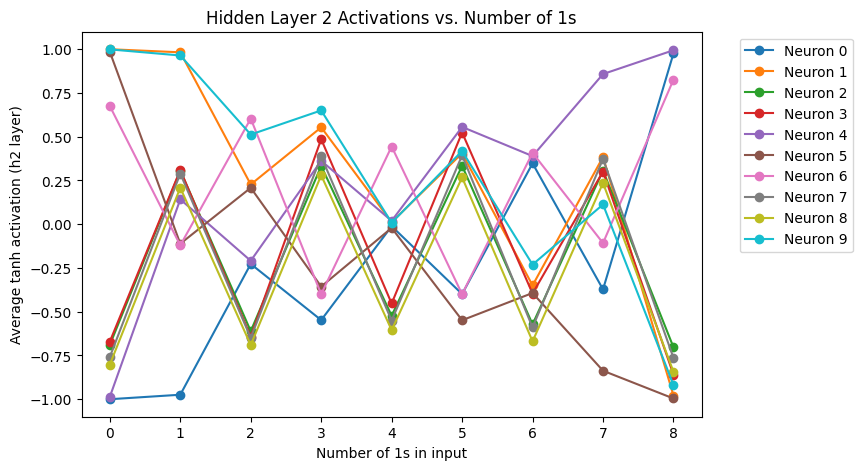

In [13]:
#Plot average activation vs. number of 1's
plt.figure(figsize=(8,5))

for i in range(all_h2.shape[1]):
  plt.plot(range(num_weights), avg_activations[:, i].numpy(), marker='o', label=f'Neuron {i}')

plt.xlabel("Number of 1s in input")
plt.ylabel("Average tanh activation (h2 layer)")
plt.title("Hidden Layer 2 Activations vs. Number of 1s")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Whoa, that's a lot of lines! Each of these represents one neuron in our **h2 activations**.


Let's zoom in on **Neuron 3**.

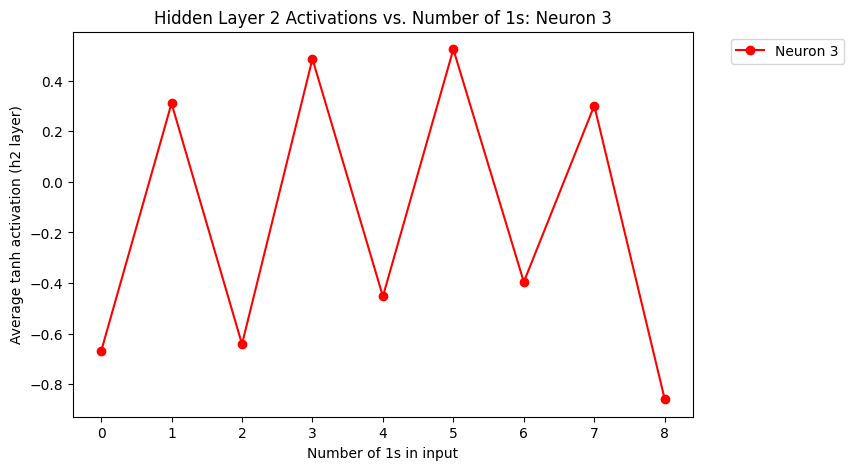

In [15]:
plt.figure(figsize=(8,5))

plt.plot(range(num_weights), avg_activations[:, 3].numpy(), marker='o', label=f'Neuron 3', color='red')

plt.xlabel("Number of 1s in input")
plt.ylabel("Average tanh activation (h2 layer)")
plt.title("Hidden Layer 2 Activations vs. Number of 1s: Neuron 3")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can see here that the zig-zag goes UP for when there are an odd number of 1's, and it goes DOWN for an even number of 1's.

This means that **Neuron 3 is parity sensitive** and that it helps the model make predictions based on how many 1's appear in the input.

Let's take a look at a **Neuron 4**, which behaves a little differently.

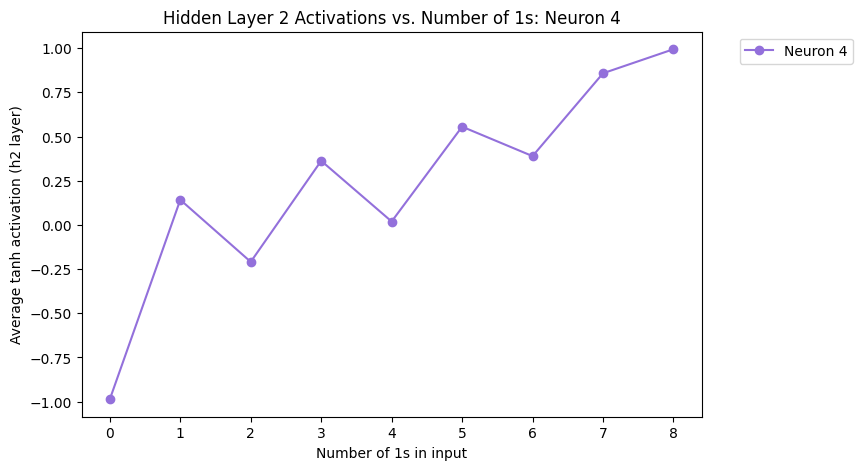

In [18]:
plt.figure(figsize=(8,5))

plt.plot(range(num_weights), avg_activations[:, 4].numpy(), marker='o', label=f'Neuron 4', color='mediumpurple')

plt.xlabel("Number of 1s in input")
plt.ylabel("Average tanh activation (h2 layer)")
plt.title("Hidden Layer 2 Activations vs. Number of 1s: Neuron 4")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Though there are still zig-zags, we can see that there seems to be a general upward trend as the number of 1's in the input increase. More 1's result in stronger activations.

So, while Neuron 3 was parity sensitive, it seems that **Neuron 4 is a counter neuron** that just accumulates a flat count of how many 1's there are, and uses that information to help inform the model's ultimate decision.

### 2.3) Neuron Ablation

What happens if one, or some neurons disappear completely? How would the model change?

We can investigate this through **neuron ablation**, where we set one neuron's values to 0 and see how the output changes.

We'll do 2 rounds of neuron ablation:
  - Single neuron ablation
  - Sweep neuron ablation

For this experiment, we'll keep the same test input as we previously had: [1, 1, 1, 0, 1, 1, 0, 0]

#### 2.3.1) Single Neuron Ablation

Our target is **Neuron 4 in Hidden Layer 2**, which we previously identified as a counter neuron. Let's set it to 0 and see how the model changes.

In [20]:
test_input = torch.tensor([[1, 1, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
true_parity = int(test_input.sum().item()) % 2 #Should be 1

#Center the input
x = 2 * test_input - 1

model.eval()

with torch.no_grad():
  #Get baseline stats
  h1_baseline = torch.tanh(model.fc1(x))
  h2_baseline = torch.tanh(model.fc2(h1_baseline))
  logit_baseline = model.fc3(h2_baseline)
  prob_baseline = torch.sigmoid(logit_baseline).item()
  pred_baseline = int(prob_baseline >= 0.5)

  #Abalation: set neuron 4 in h2 to 0
  abl_neuron = 4
  h2_abl = h2_baseline.clone()
  h2_abl[:, abl_neuron] = 0
  logit_abl = model.fc3(h2_abl)
  prob_abl = torch.sigmoid(logit_abl).item()
  pred_abl = int(prob_abl >= 0.5)

#Print results
print(f"Test input: {test_input.tolist()}")
print(f"True parity: {true_parity} ({'Odd' if true_parity==1 else 'Even'})")
print(f"Baseline logit: {logit_baseline.item():.4f}, prob: {prob_baseline:.4f}, pred: {pred_baseline}")
print(f"Ablated logit: {logit_abl.item():.4f}, prob: {prob_abl:.4f}, pred: {pred_abl}")

delta_logit = logit_abl.item() - logit_baseline.item()
delta_prob  = prob_abl - prob_baseline
print(f"Change in logit: {delta_logit:+.4f}")
print(f"Change in prob: {delta_prob:+.4f}")

Test input: [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]]
True parity: 1 (Odd)
Baseline logit: 3.8859, prob: 0.9799, pred: 1
Ablated logit: 2.9554, prob: 0.9505, pred: 1
Change in logit: -0.9304
Change in prob: -0.0294


Before ablation, the model had 97% confidence that the input is odd. But, after we ablated neuron 4 in hidden layer 2, the **prediction stays odd but with 2% lower confidence**.

Ablating neuron 4 reduces the evidence leading to an odd parity prediction by $e^{0.93} = 2.5 \times$

So, neuron 4 contributes to predicting odd parity, but other neurons are able to cover for its function, so **it is not super crucial**.

#### 2.3.2) Sweep Neuron Ablation

Now, let's look at what happens when we ablate different neurons in each of the layers.

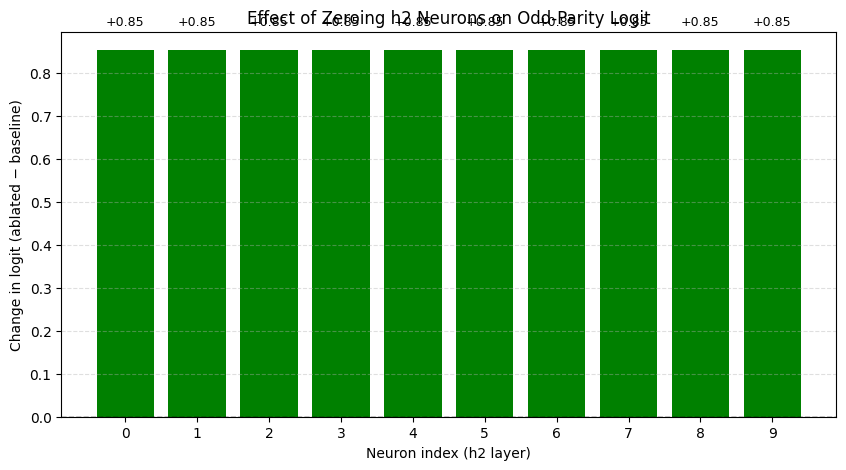

In [27]:
test_input = torch.tensor([[1, 1, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
true_parity = int(test_input.sum().item()) % 2 #Should be 1

#Center the input
x = 2 * test_input - 1

model.eval()

with torch.no_grad():
  #Get baseline stats
  h1_baseline = torch.tanh(model.fc1(x))
  h2_baseline = torch.tanh(model.fc2(h1_baseline))
  logit_baseline = model.fc3(h2_baseline).item()

#Sweep: zero each neuron in h2
abl_neuron_idxs = list(range(h2_baseline.shape[1]))
delta_logits = []

with torch.no_grad():
  for i in abl_neuron_idxs:
    h2_abl = h2_baseline.clone()
    h2_abl[:, 1] = 0
    logit_abl = model.fc3(h2_abl).item()
    delta_logits.append(logit_abl - logit_baseline)

#Plot
plt.figure(figsize=(10, 5))
colors = ['red' if d < 0 else 'green' if d > 0 else 'gray' for d in delta_logits]
plt.bar(abl_neuron_idxs, delta_logits, color=colors)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(abl_neuron_idxs)
plt.xlabel("Neuron index (h2 layer)")
plt.ylabel("Change in logit (ablated − baseline)")
plt.title("Effect of Zeroing h2 Neurons on Odd-Parity Logit")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

#Label bars
for i, d in enumerate(delta_logits):
  if abs(d) > 1e-3:
    plt.text(i, d + (0.05 if d > 0 else -0.08), f"{d:+.2f}",
              ha='center', va='bottom' if d > 0 else 'top', fontsize=9)
plt.show()

In [28]:
print(f"Test input (binary): {test_input.tolist()}")
print(f"True parity: {true_parity} ({'Odd' if true_parity==1 else 'Even'})")
print(f"Baseline logit: {logit_baseline:.4f}  (prob={torch.sigmoid(torch.tensor(logit_baseline)).item():.4f})")
for i, d in enumerate(delta_logits):
    if abs(d) > 1e-3:
        direction = "decreased" if d < 0 else "increased"
        print(f"h2[{i}] ablation → logit {direction} by {abs(d):.3f}")

Test input (binary): [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]]
True parity: 1 (Odd)
Baseline logit: 3.8859  (prob=0.9799)
h2[0] ablation → logit increased by 0.854
h2[1] ablation → logit increased by 0.854
h2[2] ablation → logit increased by 0.854
h2[3] ablation → logit increased by 0.854
h2[4] ablation → logit increased by 0.854
h2[5] ablation → logit increased by 0.854
h2[6] ablation → logit increased by 0.854
h2[7] ablation → logit increased by 0.854
h2[8] ablation → logit increased by 0.854
h2[9] ablation → logit increased by 0.854


Interestingly, for each of the neurons in h2, ablating them made the model more confident in an odd parity. In other words, all these neurons contribute negatively to the odd prediction.

The same value for all of them indicates the layer is balanced (each neuron has the same effect), and **there is no one crucial neuron that has the greatest importance**.

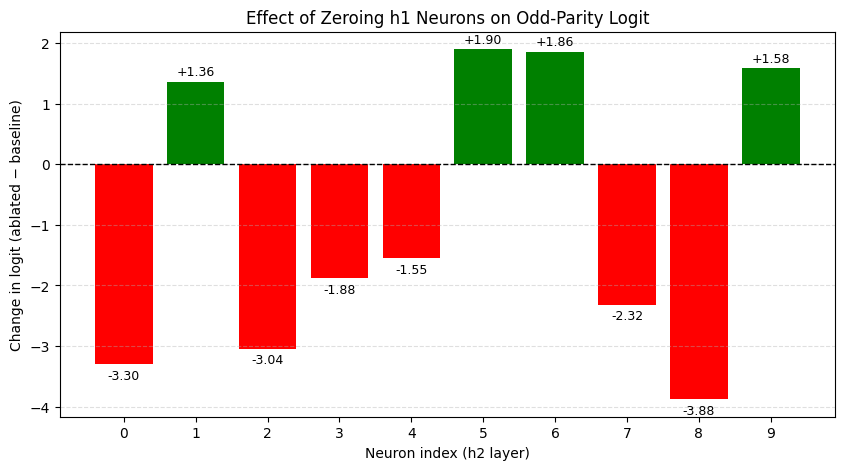

In [29]:
test_input = torch.tensor([[1, 1, 1, 0, 1, 1, 0, 0]], dtype=torch.float32)
true_parity = int(test_input.sum().item()) % 2 #Should be 1

#Center the input
x = 2 * test_input - 1

model.eval()

with torch.no_grad():
  #Get baseline stats
  h1_baseline = torch.tanh(model.fc1(x))
  h2_baseline = torch.tanh(model.fc2(h1_baseline))
  logit_baseline = model.fc3(h2_baseline).item()

#Sweep: zero each neuron in h2
abl_neuron_idxs = list(range(h2_baseline.shape[1]))
delta_logits = []

with torch.no_grad():
  for i in abl_neuron_idxs:
    h1_abl = h1_baseline.clone(); h1_abl[:, i] = 0.0
    h2_from_h1 = torch.tanh(model.fc2(h1_abl))
    logit_abl = model.fc3(h2_from_h1).item()
    delta_logits.append(logit_abl - logit_baseline)

#Plot
plt.figure(figsize=(10, 5))
colors = ['red' if d < 0 else 'green' if d > 0 else 'gray' for d in delta_logits]
plt.bar(abl_neuron_idxs, delta_logits, color=colors)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(abl_neuron_idxs)
plt.xlabel("Neuron index (h2 layer)")
plt.ylabel("Change in logit (ablated − baseline)")
plt.title("Effect of Zeroing h1 Neurons on Odd-Parity Logit")
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

#Label bars
for i, d in enumerate(delta_logits):
  if abs(d) > 1e-3:
    plt.text(i, d + (0.05 if d > 0 else -0.08), f"{d:+.2f}",
              ha='center', va='bottom' if d > 0 else 'top', fontsize=9)
plt.show()

In [30]:
print(f"Test input (binary): {test_input.tolist()}")
print(f"True parity: {true_parity} ({'Odd' if true_parity==1 else 'Even'})")
print(f"Baseline logit: {logit_baseline:.4f}  (prob={torch.sigmoid(torch.tensor(logit_baseline)).item():.4f})")
for i, d in enumerate(delta_logits):
    if abs(d) > 1e-3:
        direction = "decreased" if d < 0 else "increased"
        print(f"h1[{i}] ablation → logit {direction} by {abs(d):.3f}")

Test input (binary): [[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0]]
True parity: 1 (Odd)
Baseline logit: 3.8859  (prob=0.9799)
h1[0] ablation → logit decreased by 3.303
h1[1] ablation → logit increased by 1.362
h1[2] ablation → logit decreased by 3.041
h1[3] ablation → logit decreased by 1.883
h1[4] ablation → logit decreased by 1.551
h1[5] ablation → logit increased by 1.900
h1[6] ablation → logit increased by 1.857
h1[7] ablation → logit decreased by 2.321
h1[8] ablation → logit decreased by 3.878
h1[9] ablation → logit increased by 1.584


The results of ablating neurons in hidden layer 1 are much more varied.
- Red bars indicate that the neuron supports **odd** parity decisions
  - **Neurons 0, 2, 3, 4, 7, and 8** support odd parity
- Green bars represent neurons that support **even** parity decisions
  - **Neurons 1, 5, 6, 9** support even parity

So, the **neurons in the first hidden layer encode competing subgroups of neurons** and have more influence in affecting parity decision than those in hidden layer 2.



## 3) Part 3: Explanation

Based on our investigations, it seems that **neuron 4 in hidden layer 2 is a counting/strength neuron**.

From the ablation studies, we saw that it wasn't the only one that contributes to an odd parity decision, since it is balanced across the neurons.

Instead, it would be better characterized as a **confidence amplifier** which strengthens the odd parity decision when there are more 1s present in the input.

(See visualizations in Part 2)

## 4) Part 4: Reflection

- Through this assignment, I learned how the different neurons in hidden layers 1 and 2 impacted the model's decision in whether an input was even or odd parity (for XOR classification). Specifically, I learned how **neuron 4 in hidden layer 2** acts as a confidence amplifier for odd parity decisions that other neurons (like neuron 3 in hidden layer 2) arrive at.

- The ablation study of hidden layer 2 surprised me because I did not expect all the bars to be the same value. However, my understanding was improved when I performed the ablation in hidden layer 1, which is where more information regarding neuron influence on parity decision was contained since the neurons in that layer interact with the raw data.

- It's challenging deciding what neurons in what layers to look at. Even for this simple MLP that only had 2 layers, there were many aspects that I didn't thoroughly investigate (e.g. ablating different combinations of hidden layer 1 and hidden layer 2 neurons). This issue would only be exacerbated in larger multilayer networks.